# Quick Start

The PairInteraction software allows for the calculation of properties of Rydberg atoms and Rydberg pair potentials, optionally considering electric and magnetic fields in arbitrary directions.
The software is written so that it works for atoms with a single valence electron as well as for atoms which require multi-channel quantum defect theory.
To achieve a high performance, the backend of the software is written in C++ and wrapped with nanobind, providing a Python interface and graphical user interface.
The software can be installed via `pip` with the following command on Linux, macOS, and Windows:

```bash
pip install pairinteraction
```

The construction of Hamiltonians is accelerated by using pre-calculated matrix elements, which are stored in database tables.
These tables are automatically downloaded from GitHub when needed \[[1](https://github.com/pairinteraction/database-sqdt/releases),[2](https://github.com/pairinteraction/database-mqdt/releases)\].
Once the tables are downloaded, they are cached locally and the software can be used without an internet connection.
To download tables manually, for example, the tables for Rubidium and Yb171 (for a full list of supported species, see the "Identifier" column in the "quantum defect references" table of PairInteraction's [README](https://www.pairinteraction.org/pairinteraction/stable/index.html#quantum-defects)), run:

```bash
pairinteraction download Rb Yb171_mqdt
```

To test the software, run:

```bash
pairinteraction --log-level INFO test
```

To start the graphical user interface, run:

```bash
pairinteraction --log-level INFO gui
```


## Using the Python Interface

Import the necessary libraries and initialize PairInteraction's database that contains pre-calculated atomic states and matrix elements. By setting `download_missing=True`, database tables are automatically downloaded from GitHub when needed.

In [ ]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction as pi  # use `import pairinteraction.real as pi` for better performance
from pairinteraction.visualization.colormaps import alphamagma

if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

The library is structured around Python classes that can be used to model systems of Rydberg atoms. In the following, we describe a system of a single Rydberg atom and calculate the energy shift due to an electric and magnetic field.

In [5]:
# Construct and diagonalize the Hamiltonian of a single Rydberg atom in an electric and
# magnetic field
ket = pi.KetAtom("Rb", n=60, l=0, m=0.5)
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(ket.l - 3, ket.l + 3))
system = (
    pi.SystemAtom(basis)
    .set_electric_field([0, 0, 0.5], unit="V/cm")
    .set_magnetic_field([0, 0, 10], unit="gauss")
)
pi.diagonalize(
    [system], diagonalizer="lapacke_evd", float_type="float64"
)  # Use "float32" for faster calculations

# Obtain energy of the eigenstate with largest overlap with the ket we are interested in
energy_shifted = system.get_corresponding_energy(ket, unit="GHz")

# Show the energy shift
print(f"Energy shift: {energy_shifted - ket.get_energy(unit='GHz'):.3f} GHz")

Energy shift: -0.009 GHz


Two single-atom systems can be combined to model a pair of atoms. In the following, we show how to calculate the pair potential for the ket state that we have specified above.

Number of states in the pair basis: 343


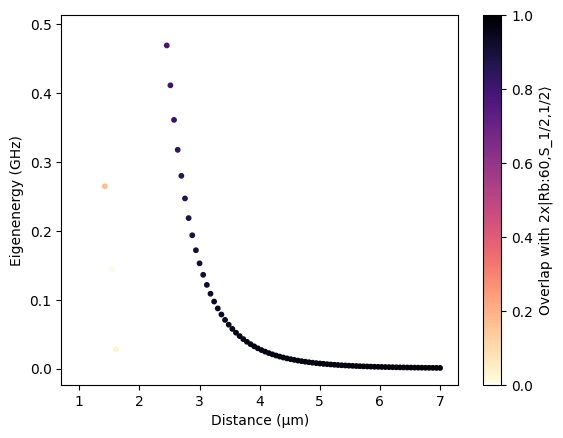

In [ ]:
# Construct and diagonalize the Hamiltonian for a pair of Rydberg atoms at different distances
distances = np.linspace(1, 7, 100)  # in micrometers
pair_energy = 2 * energy_shifted
pair_basis = pi.BasisPair(
    [system, system],
    energy=(pair_energy - 10, pair_energy + 10),
    energy_unit="GHz",
    m=(2 * ket.m, 2 * ket.m),
)
print(f"Number of states in the pair basis: {pair_basis.number_of_states}")

pair_systems = [
    pi.SystemPair(pair_basis).set_distance_vector([0, 0, d], unit="micrometer")
    for d in distances
]
pi.diagonalize(
    pair_systems,
    diagonalizer="lapacke_evr",
    float_type="float64",
    energy_range=(pair_energy, pair_energy + 0.5),
    energy_range_unit="GHz",
)

# Obtain the eigenenergies and the overlaps with the ket we are interested in
pair_eigenenergies = [s.get_eigenenergies(unit="GHz") for s in pair_systems]
pair_overlaps = [s.get_eigenbasis().get_overlaps([ket, ket]) for s in pair_systems]

# Plot the pair potentials
distances_repeated = np.hstack(
    [d * np.ones_like(e) for d, e in zip(distances, pair_eigenenergies)]
)
pair_eigenenergies_flattened = np.hstack(pair_eigenenergies)
pair_overlaps_flattened = np.hstack(pair_overlaps)
sorter = np.argsort(pair_eigenenergies_flattened)

scat = plt.scatter(
    distances_repeated[sorter],
    pair_eigenenergies_flattened[sorter] - pair_energy,
    c=pair_overlaps_flattened[sorter],
    s=10,
    cmap=alphamagma,
    vmin=0,
    vmax=1,
)
plt.colorbar(scat, label=f"Overlap with 2x{ket}")
plt.xlabel("Distance (μm)")
plt.ylabel("Eigenenergy (GHz)")
plt.show()

In addition to these basic functionalities, the PairInteraction library comes with methods for the perturbative calculation of effective Hamiltonians and the calculation of properties of Rydberg atoms, such as lifetimes. For examples, see the corresponding tutorials.